In [1]:
import torch
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
import pandas as pd
from torchvision import datasets
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler


In [2]:
#images = "/home/bandyadkas/cellcyle/data/"
images = "/mnt/efs/woods_hole/bbbc_cellcycle/model_data/data/"

In [3]:
transform = {
        'train': transforms.Compose([
            #transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            #transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            #transforms.Resize([224,224]),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0), std=(1))
        ])
    }

In [4]:
all_images_raw = datasets.ImageFolder(images,transform=transform['train'])
print(len(all_images_raw))
#all_images = torchvision.datasets.DatasetFolder(
#    "/mnt/efs/woods_hole/bbbc_cellcycle/CellCycle/",
#    imageio.imread, ("merged.jpg"), transform=transform)
#print(len(all_images))

32266


In [5]:
import copy
print(all_images_raw.class_to_idx)
new_classIds = {'G1': 0, 'S': 1, 'G2': 2, 'Prophase': 3, 'Metaphase': 4, 'Anaphase': 5, 'Telophase': 6}
all_images_new_classIDs = copy.deepcopy(all_images_raw)
all_images_new_classIDs.class_to_idx = new_classIds
print(all_images_new_classIDs.class_to_idx)

{'Anaphase': 0, 'G1': 1, 'G2': 2, 'Metaphase': 3, 'Prophase': 4, 'S': 5, 'Telophase': 6}
{'G1': 0, 'S': 1, 'G2': 2, 'Prophase': 3, 'Metaphase': 4, 'Anaphase': 5, 'Telophase': 6}


In [6]:
sines = np.sin(2 * np.pi*np.array(all_images_new_classIDs.targets)/7)
cosines = np.cos(2 * np.pi*np.array(all_images_new_classIDs.targets)/7)

#print(np.shape(sines), np.shape(cosines))
sine_cosine_targets = np.stack((sines,cosines),axis=1)
#print(np.shape(sine_cosine_targets))


all_images_circ_targets = copy.deepcopy(all_images_new_classIDs)
all_images_circ_targets.targets = sine_cosine_targets

#print(np.shape(all_images_raw.targets))
#print(np.shape(all_images_new_classIDs.targets))
#print(np.shape(all_images_circ_targets.targets))
assert np.shape(all_images_circ_targets.targets)==(32266,2)


In [7]:
train_size = int(0.7 * len(all_images_circ_targets))
val_size = int(0.15 * len(all_images_circ_targets))
test_size = len(all_images_circ_targets) - (train_size + val_size)
print(train_size, val_size, test_size)
assert train_size + val_size + test_size == len(all_images_circ_targets)

22586 4839 4841


In [8]:
train_set, val_set, test_set = torch.utils.data.random_split(all_images_circ_targets, [train_size, val_size, test_size])
#train_set, val_set, test_set = torch.utils.data.random_split(all_images, [22538, 4829, 4831])

  1%|█▏                                                                                | 68/4841 [00:00<00:14, 339.88it/s]

5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
4 4.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3


  3%|██▎                                                                              | 139/4841 [00:00<00:13, 344.97it/s]

1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
4 4.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
4 4.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3


  4%|███▍                                                                             | 208/4841 [00:00<00:13, 334.56it/s]

4 4.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
4 4.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
0 0.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
4 4.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3


  5%|████                                                                             | 243/4841 [00:00<00:13, 336.81it/s]

5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3


  6%|█████▏                                                                           | 312/4841 [00:00<00:13, 332.45it/s]

5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
4 4.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
2 2.3


  8%|██████▎                                                                          | 380/4841 [00:01<00:13, 328.89it/s]

1 1.3
1 1.3
5 5.3
4 4.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
3 3.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
4 4.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3


  9%|███████▍                                                                         | 446/4841 [00:01<00:13, 317.59it/s]

2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3


 11%|████████▌                                                                        | 514/4841 [00:01<00:13, 325.94it/s]

1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3


 12%|█████████▋                                                                       | 581/4841 [00:01<00:13, 326.52it/s]

1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
4 4.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3


 13%|██████████▊                                                                      | 647/4841 [00:01<00:13, 318.73it/s]

5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3


 15%|███████████▉                                                                     | 715/4841 [00:02<00:12, 326.95it/s]

1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
6 6.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3


 16%|█████████████                                                                    | 784/4841 [00:02<00:12, 333.17it/s]

1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3


 18%|██████████████▎                                                                  | 852/4841 [00:02<00:12, 330.72it/s]

2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
4 4.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
4 4.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3


 19%|███████████████▍                                                                 | 920/4841 [00:02<00:11, 329.72it/s]

1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
4 4.3
2 2.3
1 1.3


 20%|████████████████▌                                                                | 989/4841 [00:02<00:11, 334.38it/s]

2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
4 4.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3


 22%|█████████████████▍                                                              | 1057/4841 [00:03<00:11, 331.28it/s]

5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3


 23%|██████████████████▌                                                             | 1125/4841 [00:03<00:11, 330.52it/s]

1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3


 25%|███████████████████▋                                                            | 1192/4841 [00:03<00:11, 328.24it/s]

5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
4 4.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
4 4.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3


 26%|████████████████████▊                                                           | 1259/4841 [00:03<00:10, 328.79it/s]

5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
4 4.3
1 1.3
2 2.3
1 1.3
1 1.3


 27%|█████████████████████▉                                                          | 1325/4841 [00:04<00:11, 297.65it/s]

5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3


 29%|███████████████████████                                                         | 1392/4841 [00:04<00:10, 314.73it/s]

1 1.3
5 5.3
5 5.3
4 4.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
4 4.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3


 30%|████████████████████████▏                                                       | 1460/4841 [00:04<00:10, 326.02it/s]

4 4.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
4 4.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
4 4.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3


 32%|█████████████████████████▎                                                      | 1529/4841 [00:04<00:09, 331.93it/s]

1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
3 3.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3


 33%|██████████████████████████▍                                                     | 1599/4841 [00:04<00:09, 336.21it/s]

5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3


 34%|███████████████████████████▌                                                    | 1667/4841 [00:05<00:09, 329.94it/s]

1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3


 36%|████████████████████████████▋                                                   | 1735/4841 [00:05<00:15, 197.95it/s]

2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
4 4.3
2 2.3
1 1.3
4 4.3
1 1.3
2 2.3
2 2.3
2 2.3
4 4.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3


 37%|█████████████████████████████▋                                                  | 1799/4841 [00:05<00:12, 242.22it/s]

2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
4 4.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
0 0.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
4 4.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3


 38%|██████████████████████████████▊                                                 | 1862/4841 [00:06<00:11, 267.99it/s]

2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3


 40%|███████████████████████████████▊                                                | 1924/4841 [00:06<00:10, 282.15it/s]

5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
3 3.3
5 5.3
1 1.3
5 5.3


 41%|████████████████████████████████▊                                               | 1987/4841 [00:06<00:09, 296.82it/s]

5 5.3
4 4.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
4 4.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3


 42%|█████████████████████████████████▉                                              | 2053/4841 [00:06<00:08, 312.11it/s]

1 1.3
1 1.3
1 1.3
4 4.3
2 2.3
2 2.3
1 1.3
1 1.3
4 4.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
4 4.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
2 2.3


 44%|███████████████████████████████████                                             | 2118/4841 [00:06<00:08, 313.99it/s]

5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
4 4.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
4 4.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3


 45%|████████████████████████████████████                                            | 2185/4841 [00:07<00:08, 316.66it/s]

2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
4 4.3
2 2.3
6 6.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
3 3.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3


 46%|████████████████████████████████████▋                                           | 2217/4841 [00:07<00:08, 310.14it/s]

1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
4 4.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
4 4.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3


 47%|█████████████████████████████████████▋                                          | 2282/4841 [00:07<00:08, 316.37it/s]

1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
4 4.3
1 1.3
2 2.3
1 1.3
1 1.3


 48%|██████████████████████████████████████▊                                         | 2346/4841 [00:07<00:07, 316.52it/s]

1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
4 4.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3


 50%|███████████████████████████████████████▊                                        | 2410/4841 [00:07<00:07, 313.18it/s]

2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3


 51%|████████████████████████████████████████▉                                       | 2474/4841 [00:07<00:07, 313.38it/s]

2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
3 3.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
4 4.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3


 52%|█████████████████████████████████████████▉                                      | 2539/4841 [00:08<00:07, 316.98it/s]

5 5.3
5 5.3
4 4.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3


 54%|███████████████████████████████████████████                                     | 2605/4841 [00:08<00:06, 320.67it/s]

1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
4 4.3
1 1.3
5 5.3


 55%|████████████████████████████████████████████▏                                   | 2672/4841 [00:08<00:06, 321.93it/s]

1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3


 57%|█████████████████████████████████████████████▎                                  | 2740/4841 [00:08<00:06, 328.95it/s]

1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3


 58%|██████████████████████████████████████████████▍                                 | 2809/4841 [00:08<00:06, 331.93it/s]

1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
4 4.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
4 4.3
1 1.3
5 5.3
1 1.3
4 4.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3


 59%|██████████████████████████████████████████████▉                                 | 2843/4841 [00:09<00:06, 327.40it/s]

1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3


 60%|████████████████████████████████████████████████                                | 2910/4841 [00:09<00:07, 257.74it/s]

5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
6 6.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
4 4.3
5 5.3
5 5.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
4 4.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
4 4.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3


 62%|█████████████████████████████████████████████████▎                              | 2981/4841 [00:09<00:06, 297.17it/s]

1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
4 4.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3


 63%|██████████████████████████████████████████████████▍                             | 3051/4841 [00:09<00:05, 320.59it/s]

1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
4 4.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
6 6.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
2 2.3
4 4.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
6 6.3
1 1.3
2 2.3
2 2.3
4 4.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3


 64%|███████████████████████████████████████████████████▌                            | 3121/4841 [00:10<00:05, 333.47it/s]

2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
4 4.3
4 4.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
4 4.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
4 4.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3


 66%|████████████████████████████████████████████████████▋                           | 3191/4841 [00:10<00:04, 334.35it/s]

1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3


 67%|█████████████████████████████████████████████████████▉                          | 3261/4841 [00:10<00:04, 324.46it/s]

5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3


 69%|██████████████████████████████████████████████████████▉                         | 3328/4841 [00:10<00:04, 328.83it/s]

1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
4 4.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
4 4.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3


 70%|████████████████████████████████████████████████████████▏                       | 3399/4841 [00:10<00:04, 339.13it/s]

1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
4 4.3
1 1.3
1 1.3
4 4.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
0 0.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
4 4.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3


 71%|████████████████████████████████████████████████████████▋                       | 3434/4841 [00:10<00:04, 328.36it/s]

2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
4 4.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3


 72%|█████████████████████████████████████████████████████████▊                      | 3500/4841 [00:11<00:04, 317.01it/s]

2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
0 0.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3


 74%|██████████████████████████████████████████████████████████▉                     | 3564/4841 [00:11<00:04, 312.48it/s]

2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3
4 4.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3


 75%|███████████████████████████████████████████████████████████▉                    | 3629/4841 [00:11<00:03, 312.88it/s]

5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3


 76%|█████████████████████████████████████████████████████████████                   | 3693/4841 [00:11<00:03, 311.66it/s]

2 2.3
3 3.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
4 4.3
2 2.3
5 5.3
5 5.3
4 4.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3


 78%|██████████████████████████████████████████████████████████████                  | 3757/4841 [00:12<00:03, 309.65it/s]

5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
4 4.3
2 2.3
1 1.3


 79%|███████████████████████████████████████████████████████████████                 | 3819/4841 [00:12<00:03, 309.66it/s]

1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3


 80%|████████████████████████████████████████████████████████████████▏               | 3883/4841 [00:12<00:03, 314.37it/s]

5 5.3
2 2.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3


 82%|█████████████████████████████████████████████████████████████████▏              | 3948/4841 [00:12<00:02, 316.31it/s]

2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
4 4.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
4 4.3
2 2.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3


 83%|██████████████████████████████████████████████████████████████████▎             | 4013/4841 [00:12<00:02, 316.75it/s]

1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3


 84%|███████████████████████████████████████████████████████████████████▍            | 4080/4841 [00:13<00:02, 322.44it/s]

2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3


 86%|████████████████████████████████████████████████████████████████████▌           | 4146/4841 [00:13<00:02, 321.42it/s]

4 4.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
4 4.3
5 5.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3


 87%|█████████████████████████████████████████████████████████████████████▌          | 4211/4841 [00:13<00:02, 314.54it/s]

5 5.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3


 88%|██████████████████████████████████████████████████████████████████████▋         | 4277/4841 [00:13<00:01, 320.93it/s]

1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
4 4.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3


 89%|███████████████████████████████████████████████████████████████████████▎        | 4312/4841 [00:13<00:01, 327.12it/s]

5 5.3
5 5.3
2 2.3
2 2.3
4 4.3
1 1.3
1 1.3
1 1.3
4 4.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
2 2.3
5 5.3
1 1.3


 90%|████████████████████████████████████████████████████████████████████████▍       | 4380/4841 [00:14<00:01, 254.17it/s]

1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
4 4.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
4 4.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3


 92%|█████████████████████████████████████████████████████████████████████████▌      | 4451/4841 [00:14<00:01, 295.97it/s]

1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
4 4.3
5 5.3
2 2.3
5 5.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
2 2.3
5 5.3
2 2.3
2 2.3
2 2.3
5 5.3
2 2.3
5 5.3
2 2.3


 93%|██████████████████████████████████████████████████████████████████████████▋     | 4520/4841 [00:14<00:01, 314.47it/s]

1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
2 2.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
5 5.3
1 1.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 

 95%|███████████████████████████████████████████████████████████████████████████▊    | 4589/4841 [00:14<00:00, 326.22it/s]

5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
3 3.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
2 2.3
1 1.3
5 5.3


 96%|████████████████████████████████████████████████████████████████████████████▉   | 4657/4841 [00:14<00:00, 320.46it/s]

2 2.3
5 5.3
1 1.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
1 1.3
4 4.3
1 1.3
2 2.3
2 2.3
2 2.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
4 4.3
5 5.3
5 5.3
5 5.3
1 1.3
2 2.3
2 2.3
2 2.3
2 2.3
5 5.3
5 5.3
4 4.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3


 98%|██████████████████████████████████████████████████████████████████████████████  | 4723/4841 [00:15<00:00, 320.95it/s]

2 2.3
6 6.3
1 1.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
5 5.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
2 2.3
1 1.3
2 2.3
5 5.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
4 4.3
2 2.3
1 1.3
2 2.3
1 1.3
1 1.3


 99%|███████████████████████████████████████████████████████████████████████████████▏| 4791/4841 [00:15<00:00, 329.80it/s]

1 1.3
1 1.3
5 5.3
1 1.3
5 5.3
5 5.3
5 5.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
5 5.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
5 5.3
5 5.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
5 5.3
5 5.3
1 1.3
3 3.3
2 2.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
2 2.3
1 1.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
1 1.3
2 2.3
5 5.3
1 1.3
2 2.3
2 2.3
5 5.3


100%|████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:15<00:00, 311.98it/s]


1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
5 5.3
1 1.3
1 1.3
2 2.3
1 1.3
5 5.3
2 2.3
1 1.3
1 1.3
5 5.3
5 5.3
1 1.3
2 2.3
1 1.3
1 1.3
2 2.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3
1 1.3


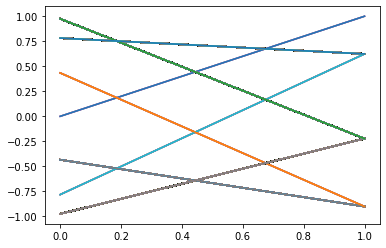

In [16]:
from tqdm import tqdm
for x, y in tqdm(test_set):
    
    true_y = y 
    pred_y = y+0.3
    #print(true_y,pred_y)

    sines = np.sin(2*np.pi*true_y/7)
    cosines = np.cos(2*np.pi*true_y/7) 
    sine_cosine_y = np.stack((sines,cosines),axis=-1)
    
    sinespred = np.sin(2*np.pi*pred_y/7)
    cosinespred = np.cos(2*np.pi*pred_y/7) 
    sine_cosine_y_pred = np.stack((sinespred,cosinespred),axis=-1)
    
    
    
    
    #print(sine_cosine_y)
    #print(sine_cosine_y_pred)
    
    plt.plot.(sine_cosine_y)

    #y = torch.from_numpy(sine_cosine_y)

    #x, y = x.to(device), y.to(device)

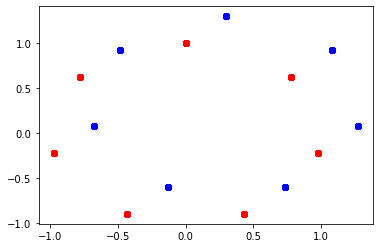

In [48]:
#print()
plt.scatter(x=test_set.dataset.targets[:,0],y=test_set.dataset.targets[:,1])

sinespred = [ypred+0.3 for ypred in test_set.dataset.targets[:,0]]
cosinespred = [ypred+0.3 for ypred in test_set.dataset.targets[:,1]]

plt.scatter(x=test_set.dataset.targets[:,0],y=test_set.dataset.targets[:,1], c='red')
plt.scatter(x=sinespred,y=cosinespred, c='blue')
    

In [50]:
regressionmodel = torch.load("/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/regressionModel.pth")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/regressionModel.pth'

In [21]:
true_y = subset
pred_y = [i+0.3 for i in subset]
print(pred_y)

[5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 5.3]
